### **Notebook 01: Exploratory Data Analysis and Quality Control**

This notebook performs a detailed exploratory data analysis (EDA) and quality control (QC) audit on the CAT2000 dataset. The analysis focuses on both the stimulus images and their corresponding fixation data across six semantic categories. This initial step ensures the integrity of the raw data and providing a baseline understanding of its properties before any complex modeling is performed.

The primary goals of this notebook:

1.  **Quality control:** To detect missing, corrupted, or inconsistent files in the raw dataset, ensuring a complete and reliable set of inputs for the pipeline.  
2.  **Descriptive statistics:** To quantify key structural properties, such as image dimensions and fixation map statistics, identifying any anomalies or patterns.  
3.  **Vision science insights:** To extract preliminary behavioral patterns from the raw gaze data, specifically testing for baseline attentional differences between anthropomorphic (images containing humans) and non-anthropomorphic scenes.  

---

### **Section 0: Setup and Configuration**

In [19]:
# --- Section 0: Setup and Configuration ---

# --- Standard libraries and third-party imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from pathlib import Path
from PIL import Image
import random
import sys
import os
from scipy.stats import ttest_1samp
from IPython.display import display, Image as IPyImage
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu

# --- Project-specific imports and configuration ---
# This assumes the notebook is in notebooks/ and config.py is in src/
sys.path.insert(0, str(Path("../src").resolve()))
import config

# --- Notebook-specific constants ---
NOTEBOOK_NUM = 1

# --- Helper Functions ---

def get_output_path(section_num: int, filename: str) -> Path:
    """Generates a standardized output path for notebook artifacts."""
    output_dir = config.RESULTS_DIR / f"notebook{NOTEBOOK_NUM:02d}" / f"section{section_num:02d}"
    output_dir.mkdir(parents=True, exist_ok=True)
    return output_dir / filename

def enforce_category_order(df: pd.DataFrame, col: str = "category") -> pd.DataFrame:
    """Casts a column to the canonical categorical ordering and returns a sorted copy."""
    if col in df.columns:
        dtype = pd.CategoricalDtype(config.CATEGORY_ORDER, ordered=True)
        out = df.copy()
        out[col] = out[col].astype(dtype)
        return out.sort_values(col)
    return df

def save_dataframe_as_markdown(df: pd.DataFrame, filepath: Path, title: str = "") -> None:
    """Saves a DataFrame to Markdown with consistent numeric formatting."""
    df_to_write = enforce_category_order(df)

    def _fmt_float(x: float) -> str:
        if pd.isna(x):
            return ""
        if 0 < abs(x) < 0.001:
            return f"{x:.2e}"
        return f"{x:.3f}"

    df_fmt = df_to_write.copy()
    for col in df_fmt.select_dtypes(include=[float]).columns:
        df_fmt[col] = df_fmt[col].map(_fmt_float)

    with open(filepath, "w", encoding="utf-8") as f:
        if title:
            f.write(f"## {title}\n\n")
        f.write(df_fmt.to_markdown(index=False))
    print(f"[saved] {filepath}")

# --- Environment Setup ---

# Set pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# Configure seaborn plotting style
_palette = [config.CATEGORY_COLORS.get(c) for c in config.CATEGORY_ORDER]
sns.set_theme(style="whitegrid", palette=_palette)

# Set random seeds for reproducibility
random.seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)

# --- Configuration Snapshot ---
print("[config] Project configuration")
for key, value in sorted(
    {k: v for k, v in config.__dict__.items() if k.isupper() and not k.startswith("_")}.items()
):
    print(f"{key:<24}: {value}")

print("\n[ok] Setup complete.")

[config] Project configuration
ANTHROPOMORPHIC_CATEGORIES: ['Action', 'Affective', 'Social']
BOXPLOT_WIDTH           : 0.45
CAT2000_DIR             : /home/nico/Projects/final_project/data/CAT2000/trainSet
CATEGORIES              : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CATEGORY_COLORS         : {'Action': '#7ad151', 'Affective': '#414487', 'Social': '#fde725', 'Indoor': '#22a884', 'OutdoorManMade': '#2a7886', 'OutdoorNatural': '#440154'}
CATEGORY_ORDER          : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CATEGORY_PALETTE        : ['#7ad151', '#414487', '#fde725', '#22a884', '#2a7886', '#440154']
CAT_ORDER               : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CENTER_BIAS_SIGMA_X_FRAC: 0.3
CENTER_BIAS_SIGMA_Y_FRAC: 0.3
DATA_DIR                : /home/nico/Projects/final_project/data
DBSCAN_EPS              : 60
DBSCAN_MIN_SAMPLES      : 15
DEFAULT_DECIMALS        : 3


---

### **Section 1: Dataset Inventory and Structural Validation**

**Objective** 

To programmatically verify the existence, completeness, and one-to-one pairing of all stimulus images (`.jpg`) and their corresponding fixation location matrices (`.mat`) for the six selected CAT2000 categories.

**Rationale** 

This initial audit will confirm that the dataset is structurally sound before any analysis begins. It prevents errors that could arise from missing files or mismatched data, ensuring that every visual stimulus has its associated ground-truth gaze data.

**Methodology** 

An inventory of all files within the relevant subdirectories of `CAT2000/trainSet/` is conducted. For each stimulus image, the presence of a corresponding fixation file (matched by filename) is checked. The counts of images, fixation files, and successful matches are compiled into a summary table.

**Inputs**

*   `config.CATEGORIES`: List of category names to be inventoried.
*   `config.STIMULI_DIR`: Path to the directory containing stimulus images.
*   `config.FIXATIONLOCS_DIR`: Path to the directory containing fixation data.

**Outputs**

*   `results/notebook01/section01/tbl_dataset_inventory.csv`: A CSV file summarizing the file counts and matches for each category.
*   `results/notebook01/section01/tbl_dataset_inventory.md`: A Markdown version of the summary table for reporting.


In [2]:
# --- Section 1: Dataset Inventory and Structural Validation ---

def perform_dataset_inventory(categories: list[str], stimuli_dir: Path, locs_dir: Path) -> pd.DataFrame:
    """Scans CAT2000 directories and verifies one-to-one pairing of stimuli and fixation files."""
    rows = []
    total_stim, total_locs = 0, 0

    for cat in categories:
        stim_path = stimuli_dir / cat
        loc_path = locs_dir / cat

        stim_files = sorted(p.name for p in stim_path.glob("*.jpg")) if stim_path.exists() else []
        loc_files = sorted(p.stem for p in loc_path.glob("*.mat")) if loc_path.exists() else []

        set_stim = {Path(s).stem for s in stim_files}
        set_locs = set(loc_files)
        matched_locs = len(set_stim & set_locs)

        rows.append({
            "Category": cat,
            "Stimuli": len(stim_files),
            "Fixation Locs (.mat)": len(loc_files),
            "Matches": matched_locs,
        })
        total_stim += len(stim_files)
        total_locs += matched_locs

    inventory_df = pd.DataFrame(rows, columns=["Category", "Stimuli", "Fixation Locs (.mat)", "Matches"])
    print("\n[summary] Overall Match Summary")
    print(f"Total Stimulus Images Found: {total_stim}")
    pct_locs = (total_locs / total_stim) if total_stim else 0.0
    print(f"Total Matched .mat Files: {total_locs} ({pct_locs:.1%} of stimuli)")

    return inventory_df

# Execute the inventory
inventory_df = perform_dataset_inventory(
    categories=list(config.CATEGORIES),
    stimuli_dir=config.STIMULI_DIR,
    locs_dir=config.FIXATIONLOCS_DIR
)

# Save and display results
inventory_csv_path = get_output_path(1, "tbl_dataset_inventory.csv")
inventory_md_path = get_output_path(1, "tbl_dataset_inventory.md")
inventory_df.to_csv(inventory_csv_path, index=False)
save_dataframe_as_markdown(inventory_df, inventory_md_path, title="Dataset Inventory")

print("\n[table] Dataset Inventory (per category)")
display(inventory_df)


[summary] Overall Match Summary
Total Stimulus Images Found: 600
Total Matched .mat Files: 600 (100.0% of stimuli)
[saved] /home/nico/Projects/final_project/results/notebook01/section01/tbl_dataset_inventory.md

[table] Dataset Inventory (per category)


Category  Stimuli  Fixation Locs (.mat)  Matches
0          Action      100                   100      100
1       Affective      100                   100      100
2          Social      100                   100      100
3          Indoor      100                   100      100
4  OutdoorManMade      100                   100      100
5  OutdoorNatural      100                   100      100

**Results**

The inventory confirms that the dataset is complete. A total of 600 stimulus images were found across the six categories. Each image has a corresponding fixation location file (`.mat`), resulting in a 100% match rate. Each category contains exactly 100 image-fixation pairs.

**Interpretation**

The perfect one-to-one correspondence between stimulus images and fixation data files indicates that the dataset is structurally intact. 

**Conclusion**

The dataset's structural integrity is verified. The analysis can proceed to the next stage of auditing the content and properties of these files.

---

### **Section 2: Image Resolution and Format Analysis**

**Objective** 

To conduct a structural audit of the stimulus image files, validating the integrity, uniformity, and consistency of image dimensions across all 600 images in the selected categories.

**Rationale** 

Verifying that all images share a uniform resolution prior to spatial analyses, as it eliminates the need for normalization or resizing that could distort gaze data. This check also serves as a data corruption audit, ensuring all image files are readable.

**Methodology** 

Each `.jpg` stimulus file is opened to extract its pixel dimensions (width and height) and compute its aspect ratio. Any file that fails to open is flagged as an error. A random visual sample is displayed for qualitative confirmation.

**Inputs**

*   `config.CATEGORIES`: List of category names.
*   `config.STIMULI_DIR`: Path to the directory containing stimulus images.

**Outputs**

*   `results/notebook01/section02/tbl_global_resolution_summary.csv`: Tables summarizing the mean, std, min, and max of image dimensions globally.
*   `results/notebook01/section02/tbl_resolution_violations.csv`: Tables reporting any images that do not conform to the expected 1920x1080 resolution.
*   `results/notebook01/section02/fig_stimulus_samples.png`: A grid of randomly sampled images for visual inspection.



[pass] All images opened successfully.
[saved] /home/nico/Projects/final_project/results/notebook01/section02/tbl_global_resolution_summary.md

[table] Global Image Resolution Summary


width  height  aspect_ratio
mean  1920.0  1080.0         1.778
std      0.0     0.0         0.000
min   1920.0  1080.0         1.778
max   1920.0  1080.0         1.778

[saved] /home/nico/Projects/final_project/results/notebook01/section02/tbl_resolution_violations.md

[table] Resolution/Aspect Checks by Category


category  images  passed  violations
0          Action     100     100           0
1       Affective     100     100           0
2          Indoor     100     100           0
3  OutdoorManMade     100     100           0
4  OutdoorNatural     100     100           0
5          Social     100     100           0


[info] Displaying random sample of stimulus images.


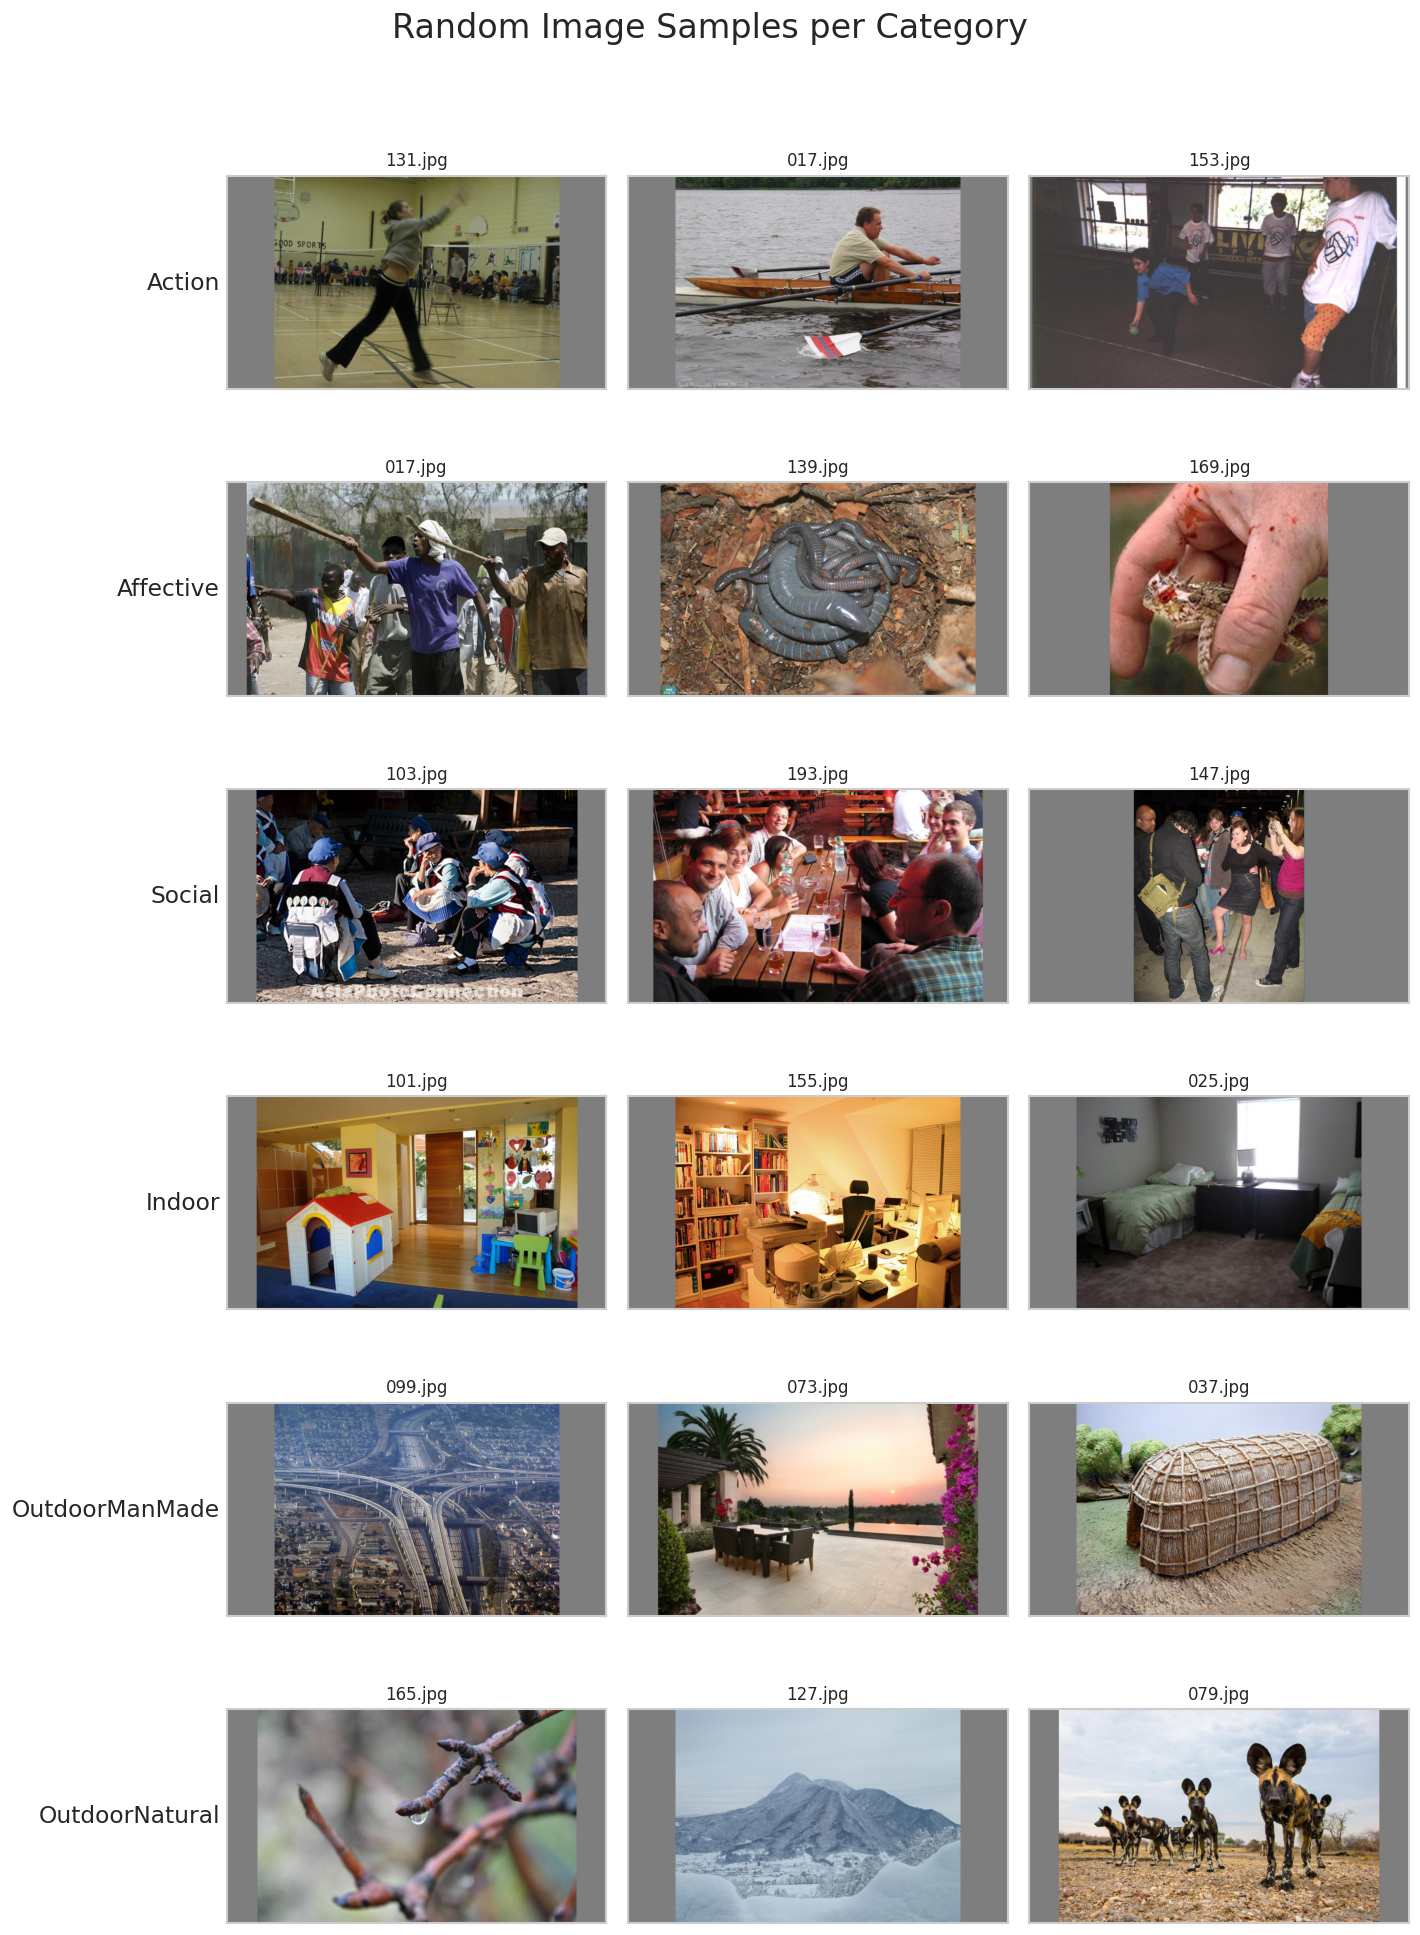

In [3]:
# --- Section 2: Image Resolution and Format Analysis ---

def analyze_image_resolutions(categories: list[str], stimuli_dir: Path) -> pd.DataFrame:
    """Analyzes stimulus image dimensions and detects unreadable files."""
    rows = []
    for cat in categories:
        cat_dir = Path(stimuli_dir) / cat
        if not cat_dir.exists():
            print(f"[warn] Missing directory for category: {cat}")
            continue
        for img_path in sorted(cat_dir.glob("*.jpg")):
            try:
                with Image.open(img_path) as im:
                    w, h = im.size
                rows.append({
                    "category": cat, "filename": img_path.name, "filepath": str(img_path),
                    "width": w, "height": h, "aspect_ratio": round(w / h, 4), "error": None
                })
            except Exception as e:
                rows.append({
                    "category": cat, "filename": img_path.name, "filepath": str(img_path),
                    "width": None, "height": None, "aspect_ratio": None, "error": str(e)
                })

    df = pd.DataFrame(rows)
    err = df[df["error"].notna()]
    if not err.empty:
        print("\n[warn] Unreadable images detected:")
        display(err[["category", "filename", "error"]])
    else:
        print("\n[pass] All images opened successfully.")
    return df

# Execute analysis
df_images = analyze_image_resolutions(list(config.CATEGORIES), config.STIMULI_DIR)

# Global summary
resolution_summary = df_images.agg(
    {"width": ["mean", "std", "min", "max"], "height": ["mean", "std", "min", "max"], "aspect_ratio": ["mean", "std", "min", "max"]}
).round(config.DEFAULT_DECIMALS)

# Save and display global summary
res_summary_csv = get_output_path(2, "tbl_global_resolution_summary.csv")
res_summary_md = get_output_path(2, "tbl_global_resolution_summary.md")
resolution_summary.to_csv(res_summary_csv)
save_dataframe_as_markdown(resolution_summary.reset_index(names="stat"), res_summary_md, title="Global Image Resolution Summary")
print("\n[table] Global Image Resolution Summary")
display(resolution_summary)

# Violations check
viol_ok = (df_images["width"] == config.IMG_WIDTH) & (df_images["height"] == config.IMG_HEIGHT) & (df_images["error"].isna())
violations_by_cat = df_images.assign(ok=viol_ok).groupby("category", observed=True).agg(
    images=("ok", "size"), passed=("ok", "sum")
).assign(violations=lambda d: d["images"] - d["passed"]).reset_index()

# Save and display violations summary
violations_csv = get_output_path(2, "tbl_resolution_violations.csv")
violations_md = get_output_path(2, "tbl_resolution_violations.md")
violations_by_cat.to_csv(violations_csv, index=False)
save_dataframe_as_markdown(violations_by_cat, violations_md, title="Resolution/Aspect Checks by Category")
print("\n[table] Resolution/Aspect Checks by Category")
display(violations_by_cat)

# Visual confirmation grid
print("\n[info] Displaying random sample of stimulus images.")
df_valid = df_images[df_images["error"].isna()].copy()
if not df_valid.empty:
    rng = np.random.default_rng(config.RANDOM_SEED)
    n_cols, n_rows = 3, len(config.CATEGORIES)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.8 * n_rows), dpi=config.FIG_DPI)
    fig.suptitle("Random Image Samples per Category", fontsize=20)
    for i, cat in enumerate(config.CATEGORIES):
        cat_df = df_valid[df_valid["category"] == cat]
        if not cat_df.empty:
            idx = rng.choice(cat_df.index, size=min(n_cols, len(cat_df)), replace=False)
            for j, (_, row) in enumerate(cat_df.loc[idx].iterrows()):
                ax = axes[i, j]
                ax.imshow(Image.open(row["filepath"]))
                ax.set_title(row["filename"], fontsize=10)
                if j == 0:
                    ax.set_ylabel(cat, rotation=0, ha="right", va="center", fontsize=14)
                ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig_path_png = get_output_path(2, "fig_stimulus_samples.png")
    fig_path_svg = get_output_path(2, "fig_stimulus_samples.svg")
    plt.savefig(fig_path_png)
    plt.savefig(fig_path_svg)
    plt.show()

**Results**

The structural audit of the stimulus images confirmed their integrity and uniformity:

*   **File integrity:** All 600 images across the six selected categories were successfully loaded, indicating no file corruption or format issues.
*   **Resolution uniformity:** The global summary statistics show a mean width of 1920 and a mean height of 1080, with a standard deviation of 0 for both. This confirms that every image has a consistent 1920x1080 pixel resolution.
*   **Aspect ratio consistency:** All images have a uniform aspect ratio of 1.778 (16:9).
*   **Violation check:** The Resolution/Aspect check found zero violations, confirming that all images meet the expected structural criteria.

**Interpretation**

The consistent resolution and aspect ratio across all stimuli are required for the subsequent spatial analyses. This uniformity eliminates the need for image normalization or resizing, procedures that could introduce artifacts or distort the spatial characteristics of the original gaze data. The visual samples provide qualitative confirmation of the dataset's diverse content within the standardized format.

**Conclusion**

The structural audit confirms that the CAT2000 stimulus set is uniform and free from corruption. 

---

### **Section 3: Fixation Map Gaze Statistics Analysis**

**Objective** 

To quantify the spatial characteristics of aggregate gaze for each stimulus by analyzing the raw fixation maps.

**Rationale** 

This analysis establishes a baseline of aggregate viewing behavior by measuring the breadth and uniformity of fixations. These metrics help differentiate between broad, exploratory viewing patterns and more concentrated, focused attention, providing a foundational layer for understanding how scene content influences gaze.

**Methodology** 

For every fixation map, three metrics are computed:

1. **Unique fixation count**: the number of pixels receiving at least one fixation.
2. **Entropy (bits)**: the Shannon entropy of the fixation probability distribution, calculated on the positive support to measure gaze uniformity. 
3. **Standard deviation of intensity**: the dispersion of fixation counts across all pixels.

**Inputs**

*   `config.CATEGORIES`: List of category names.
*   `config.FIXATIONLOCS_DIR`: Path to the directory containing `.mat` fixation data.

**Outputs**

*   `results/notebook01/section03/fixation_map_stats_full.csv`: Detailed per-image statistics.
*   `results/notebook01/section03/tbl_fixation_stats_global_summary.csv`: Global summary statistics.
*   `results/notebook01/section03/tbl_fixation_stats_by_category.csv`: Per-category summary statistics.
*   `results/notebook01/section03/fig_fixation_metrics_by_category.png`: Combined plot of all metric distributions.
*   `results/notebook01/section03/fig_fixation_metric_*.png`: Individual plots for each metric.

[saved] Detailed log: /home/nico/Projects/final_project/results/notebook01/section03/fixation_map_stats_full.csv
[saved] /home/nico/Projects/final_project/results/notebook01/section03/tbl_fixation_stats_global_summary.md

[table] Global Fixation Statistics Summary


unique_fixation_count  entropy  std_intensity
count                600.000  600.000        600.000
mean                 349.128    8.440          0.013
std                   36.051    0.153          0.001
min                  229.000    7.839          0.011
25%                  327.000    8.353          0.013
50%                  352.000    8.459          0.013
75%                  375.000    8.551          0.013
max                  457.000    8.836          0.015

[saved] /home/nico/Projects/final_project/results/notebook01/section03/tbl_fixation_stats_by_category.md

[table] Category-Level Fixation Statistics Summary


category  unique_fixation_count_mean  entropy_mean  std_intensity_mean
0          Action                      344.98         8.422               0.013
1       Affective                      357.79         8.476               0.013
2          Social                      375.82         8.550               0.013
3          Indoor                      350.15         8.446               0.013
4  OutdoorManMade                      345.15         8.426               0.013
5  OutdoorNatural                      320.88         8.318               0.012

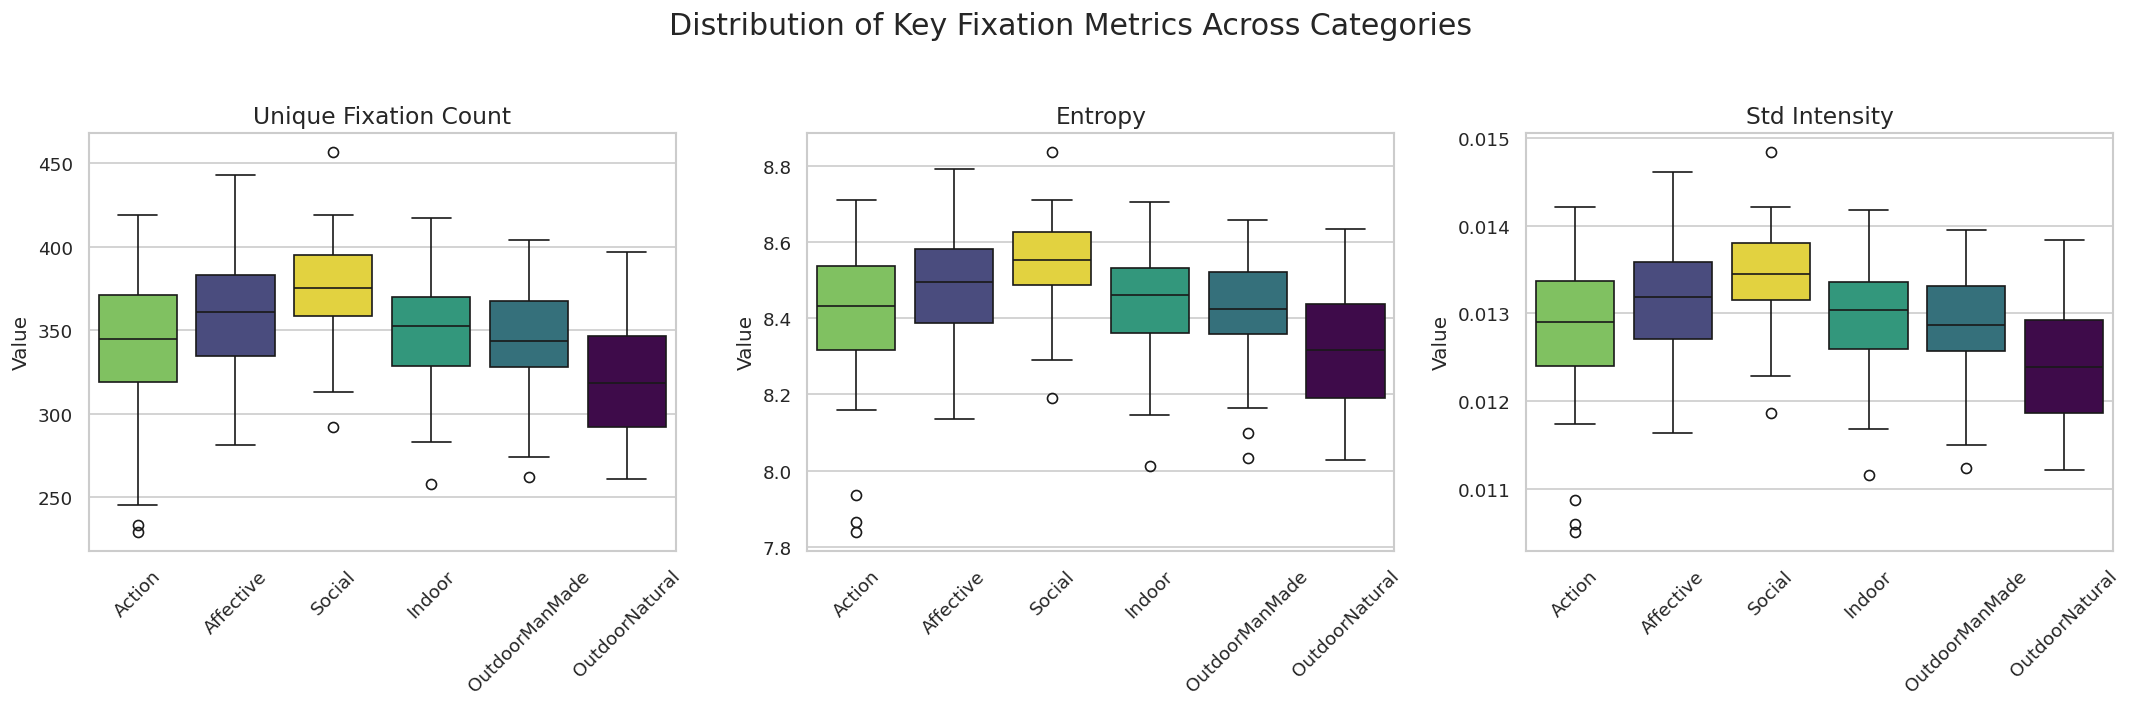

In [7]:
# --- Section 3: Fixation Map Gaze Statistics Analysis ---

def _load_fixation_mat(mat_path: Path) -> tuple[np.ndarray, int, int]:
    H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)
    if not mat_path.exists():
        raise FileNotFoundError(f"Missing fixation file: {mat_path}")
    m = scipy.io.loadmat(mat_path)
    keys = ("fixLocs","gnd","fixLocsXY","fixLocs_XY","fixations","map")
    arr = next((np.asarray(m[k]) for k in keys if k in m), None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Unknown or empty fixation format in {mat_path.name}")
    # Case A: precomputed map
    if arr.ndim == 2 and arr.shape == (H, W):
        fm = np.rint(np.clip(arr, a_min=0, a_max=None)).astype(np.int32)
        return fm, int(fm.sum()), 0
    # Case B: coordinates
    if arr.ndim == 2:
        coords = arr if arr.shape[1] == 2 else arr.T
        if coords.shape[1] != 2:
            raise ValueError(f"Fixation coords must be Nx2 or 2xN in {mat_path.name}")
        x_raw = coords[:, 0].astype(float); y_raw = coords[:, 1].astype(float)
        total = int(coords.shape[0])
        one_based = (x_raw.min() >= 1) and (y_raw.min() >= 1) and (x_raw.max() <= W) and (y_raw.max() <= H)
        if one_based:
            x_raw -= 1.0; y_raw -= 1.0
        x = np.rint(x_raw); y = np.rint(y_raw)
        oob = (x < 0) | (x >= W) | (y < 0) | (y >= H)
        xs = np.clip(x, 0, W - 1).astype(np.int32)
        ys = np.clip(y, 0, H - 1).astype(np.int32)
        fm = np.zeros((H, W), dtype=np.int32)
        np.add.at(fm, (ys, xs), 1)
        return fm, total, int(oob.sum())
    raise ValueError(f"Unhandled fixation array shape {arr.shape} in {mat_path.name}")

def _load_fixation_map_array(mat_path: Path) -> np.ndarray:
    fm, _, _ = _load_fixation_mat(mat_path)  
    return fm

def _entropy_bits_from_counts(count_map: np.ndarray) -> float:
    """Computes Shannon entropy in bits from a non-negative count map."""
    total = float(count_map.sum())
    if total <= 0.0: return 0.0
    p = count_map[count_map > 0] / total
    return float(-(p * np.log2(p)).sum())

# --- Main Analysis Function ---

def analyze_fixation_maps(categories: list[str], locs_dir: Path) -> pd.DataFrame:
    """Computes fixation-map metrics for all images across categories."""
    rows = []
    for category in categories:
        cat_dir = locs_dir / category
        for mat_file in sorted(cat_dir.glob("*.mat")):
            fixmap = _load_fixation_map_array(mat_file)
            if not np.isfinite(fixmap).all() or fixmap.sum() <= 0:
                continue
            rows.append({
                "category": category, "filename": mat_file.name,
                "unique_fixation_count": int(np.count_nonzero(fixmap)),
                "entropy": _entropy_bits_from_counts(fixmap),
                "std_intensity": float(fixmap.std(ddof=0)),
            })
    df = enforce_category_order(pd.DataFrame(rows))
    return df

# --- Execution and Output Generation ---

df_fixation = analyze_fixation_maps(list(config.CATEGORIES), config.FIXATIONLOCS_DIR)

# Save detailed per-image log
log_path = get_output_path(3, "fixation_map_stats_full.csv")
df_fixation.to_csv(log_path, index=False)
print(f"[saved] Detailed log: {log_path}")

# Generate, save, and display global summary
global_summary = df_fixation.drop(columns=["category", "filename"]).describe().round(config.DEFAULT_DECIMALS)
global_csv = get_output_path(3, "tbl_fixation_stats_global_summary.csv")
global_md = get_output_path(3, "tbl_fixation_stats_global_summary.md")
global_summary.to_csv(global_csv)
save_dataframe_as_markdown(global_summary.reset_index(names="stat"), global_md, title="Global Fixation Statistics Summary")
print("\n[table] Global Fixation Statistics Summary")
display(global_summary)

# Generate, save, and display category-level summary
category_summary = df_fixation.groupby("category", observed=True).agg(
    unique_fixation_count_mean=("unique_fixation_count", "mean"),
    entropy_mean=("entropy", "mean"),
    std_intensity_mean=("std_intensity", "mean")
).round(config.DEFAULT_DECIMALS).reset_index()
category_csv = get_output_path(3, "tbl_fixation_stats_by_category.csv")
category_md = get_output_path(3, "tbl_fixation_stats_by_category.md")
category_summary.to_csv(category_csv, index=False)
save_dataframe_as_markdown(category_summary, category_md, title="Category-Level Fixation Statistics Summary")
print("\n[table] Category-Level Fixation Statistics Summary")
display(category_summary)

# Generate and save visualizations
metrics_to_plot = ["unique_fixation_count", "entropy", "std_intensity"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=config.FIG_DPI)
fig.suptitle("Distribution of Key Fixation Metrics Across Categories", fontsize=18)
for i, metric in enumerate(metrics_to_plot):
    sns.boxplot(ax=axes[i], data=df_fixation, x="category", y=metric, hue="category", order=config.CATEGORY_ORDER, palette=config.CATEGORY_PALETTE, legend=False)
    axes[i].set_title(metric.replace("_", " ").title(), fontsize=14)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel("Value")
    axes[i].tick_params(axis="x", rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
combo_png = get_output_path(3, "fig_fixation_metrics_by_category.png")
combo_svg = get_output_path(3, "fig_fixation_metrics_by_category.svg")
plt.savefig(combo_png); plt.savefig(combo_svg)
plt.show()

**Results**

*   **Global summary:** Across all 600 stimuli, the mean unique fixation count was 349.13. The mean entropy of the fixation distribution was 8.44 bits, and the mean standard deviation of fixation intensity was 0.013.
*   **Category-wise patterns:** A consistent ordering was observed across metrics. Social scenes exhibited the highest mean unique fixation count (375.82) and entropy (8.55 bits). Outdoor Natural scenes had the lowest unique fixation count (320.88) and entropy (8.32 bits). Standard deviation of intensity remained relatively stable across all categories.

**Interpretation**

The positive correlation between unique fixation count and entropy indicates that scenes eliciting broader spatial sampling also tend to have more uniform gaze distributions. The higher values for Social and Affective categories suggest that the presence of anthropomorphic content encourages more extensive and less concentrated visual exploration. Conversely, the lower values for OutdoorNatural scenes are consistent with viewing patterns that are more focused, potentially on global layout cues or fewer, more distinct objects. The limited variance in intensity standard deviation suggests that while the *spread* of gaze varies significantly, the *peakiness* of fixations is more consistent across different types of scenes.

**Conclusion**

The analysis reveals systematic differences in aggregate gaze behavior driven by scene category. Social and Affective scenes are associated with broader, more dispersed viewing, whereas OutdoorNatural scenes are associated with narrower, more concentrated viewing. These findings motivate a more detailed investigation into the specific spatial locations of gaze, which will be addressed in the following section on centroid analysis.


---

### **Section 4: Centroid and Spatial Dispersion Analysis**

**Objective** 

To analyze the spatial distribution of fixations by computing the centroid (center of mass) and spatial dispersion (standard deviation) for each fixation map.

**Rationale** 

This analysis addresses foundational questions in vision science, allowing for a quantitative test of the center bias hypothesis and an investigation into how scene semantics systematically influence the location and spread of visual attention.

**Methodology** 

For each of the 600 `.mat` fixation maps, calculations were computed for: the intensity-weighted centroid $(\bar{x}, \bar{y})$, the intensity-weighted dispersions $(\sigma_x, \sigma_y)$, and the Euclidean distance of the centroid from the image center
$d_0=\sqrt{(\bar{x}-W/2)^2+(\bar{y}-H/2)^2}$.


**Inputs**

*   `config.CATEGORIES`: List of category names.
*   `config.FIXATIONLOCS_DIR`: Path to the directory containing `.mat` fixation data.

**Outputs**

*   `results/notebook01/section04/fixation_centroid_stats_full.csv`: Detailed per-image centroid and dispersion statistics.
*   `results/notebook01/section04/tbl_centroid_dispersion_global_summary.csv`: Global summary tables.
*   `results/notebook01/section04/tbl_centroid_dispersion_by_category.csv`: Per-category summary tables.
*   `results/notebook01/section04/fig_centroid_distribution_plots.png`: Scatter and KDE plots of centroid distributions.
*   `results/notebook01/section04/fig_gaze_dispersion_and_bias_boxplots.png`: Boxplots showing dispersion and distance-to-center metrics.

[saved] Detailed log: /home/nico/Projects/final_project/results/notebook01/section04/fixation_centroid_stats_full.csv
[saved] /home/nico/Projects/final_project/results/notebook01/section04/tbl_centroid_dispersion_global_summary.md

[table] Global Centroid and Dispersion Summary


x_mean   y_mean    x_std    y_std  distance_to_center
count   600.000  600.000  600.000  600.000             600.000
mean    976.062  528.260  264.316  186.554              78.560
std      59.185   65.758   66.201   36.910              45.183
min     647.351  348.050   89.386   98.808               2.163
25%     947.858  484.519  226.737  160.669              46.277
50%     976.777  525.364  267.789  182.575              69.693
75%    1008.621  571.087  311.088  209.425             101.072
max    1251.354  726.773  470.405  311.470             320.171

[saved] /home/nico/Projects/final_project/results/notebook01/section04/tbl_centroid_dispersion_by_category.md

[table] Category-Level Centroid and Dispersion Summary


category  distance_to_center_mean  x_std_mean  y_std_mean
0          Action                   75.809     242.381     190.790
1       Affective                   87.179     232.697     191.015
2          Social                   95.103     285.967     186.987
3          Indoor                   68.438     284.649     190.958
4  OutdoorManMade                   76.038     281.322     178.488
5  OutdoorNatural                   68.791     258.878     181.088

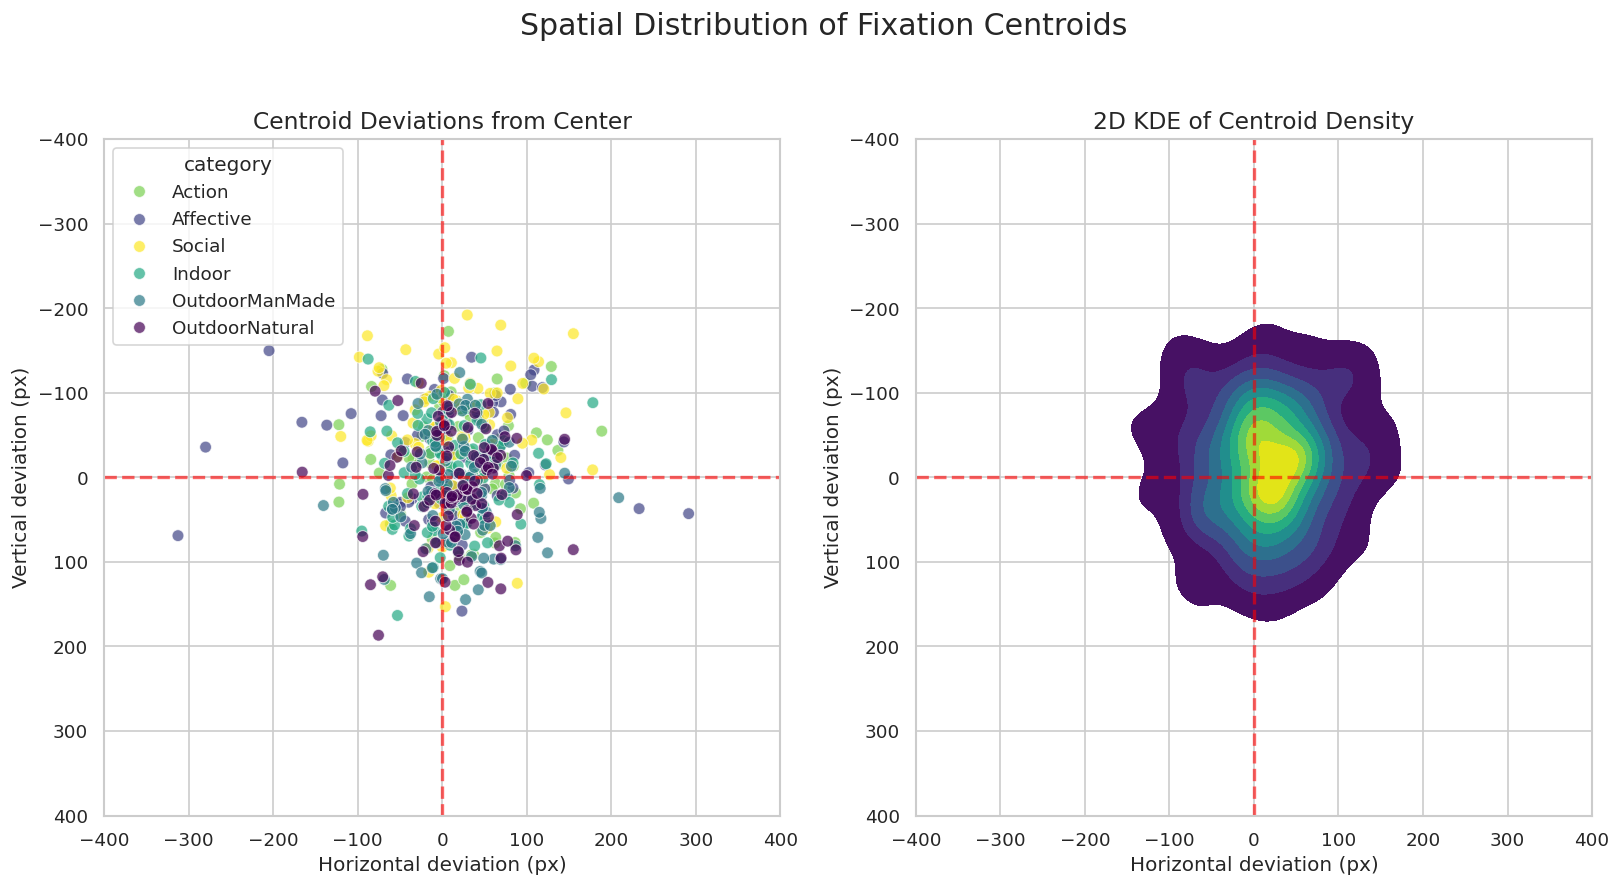

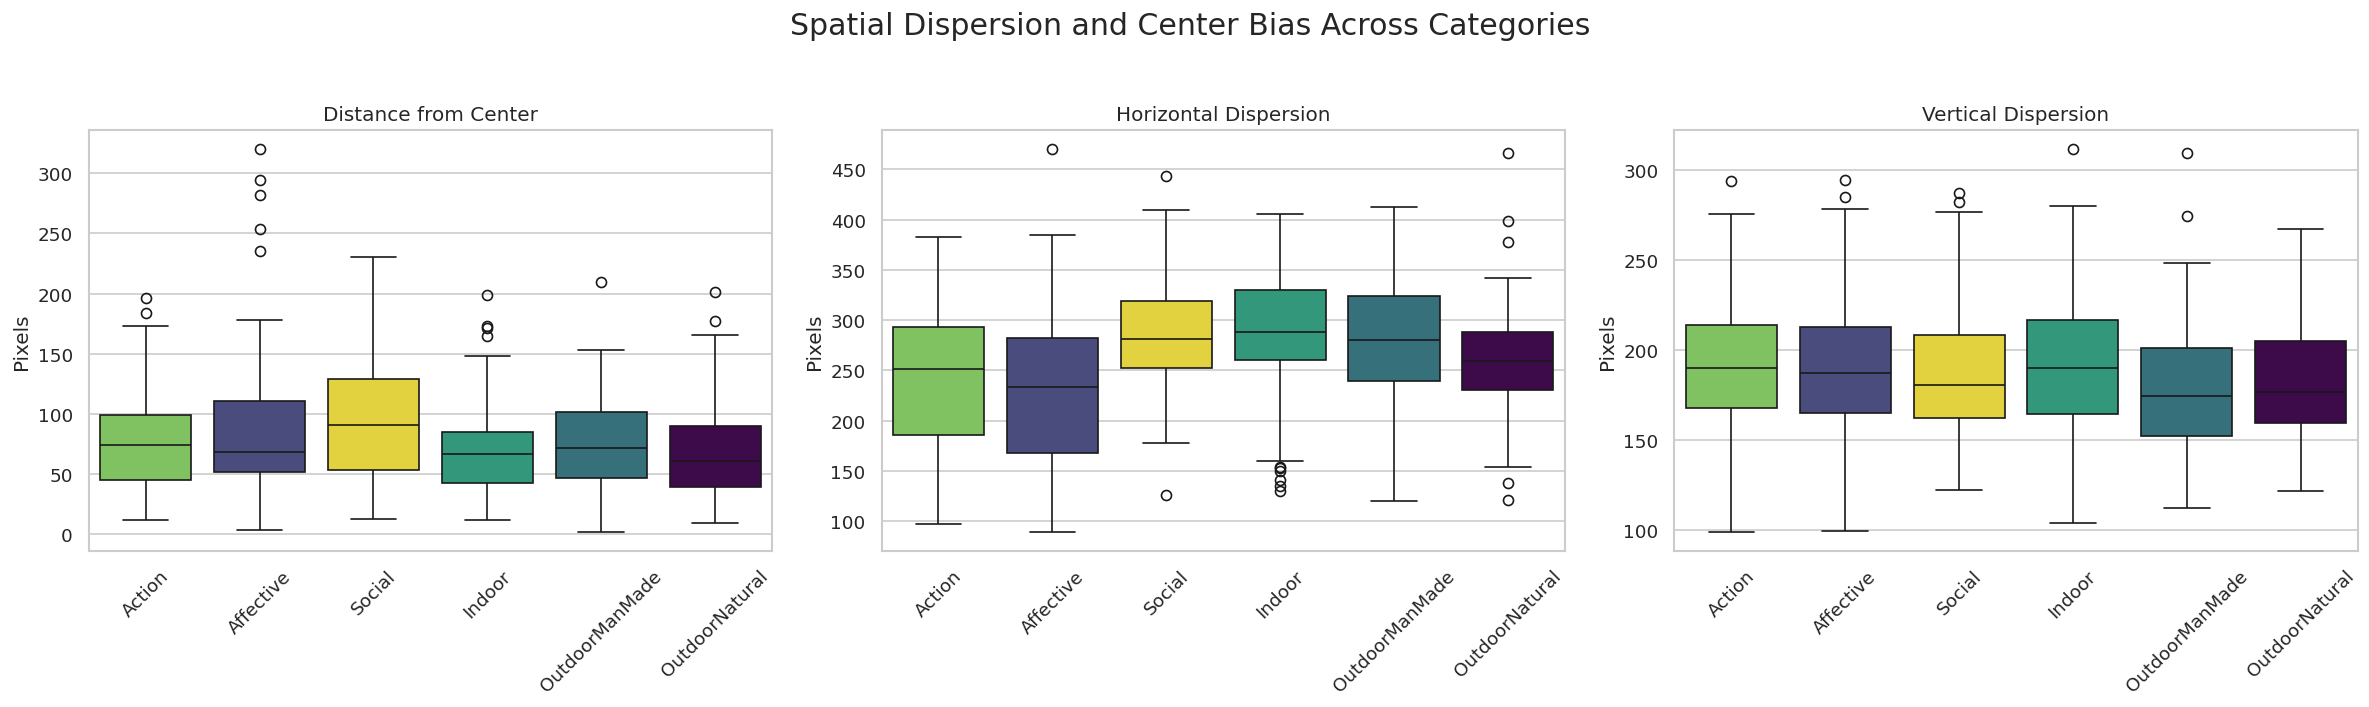

In [9]:
# --- Section 4: Centroid and Spatial Dispersion Analysis ---

def analyze_gaze_centroids(categories: list[str], locs_dir: Path, img_w: int, img_h: int) -> pd.DataFrame:
    """Computes intensity-weighted fixation centroids and dispersions."""
    rows = []
    cx, cy = img_w / 2.0, img_h / 2.0
    for category in categories:
        cat_dir = locs_dir / category
        for mat_file in sorted(cat_dir.glob("*.mat")):
            fixmap = _load_fixation_map_array(mat_file)
            total = fixmap.sum()
            if not np.isfinite(fixmap).all() or total <= 0:
                continue
            
            yy, xx = np.indices(fixmap.shape, dtype=np.float64)
            mx = float((xx * fixmap).sum() / total)
            my = float((yy * fixmap).sum() / total)
            sx = float(np.sqrt(((xx - mx) ** 2 * fixmap).sum() / total))
            sy = float(np.sqrt(((yy - my) ** 2 * fixmap).sum() / total))
            d0 = float(np.hypot(mx - cx, my - cy))
            
            rows.append({
                "category": category, "filename": mat_file.name,
                "x_mean": mx, "y_mean": my, "x_std": sx, "y_std": sy, "distance_to_center": d0
            })
    df = enforce_category_order(pd.DataFrame(rows))
    return df

# --- Execution ---
df_centroids = analyze_gaze_centroids(list(config.CATEGORIES), config.FIXATIONLOCS_DIR, config.IMG_WIDTH, config.IMG_HEIGHT)

# Save detailed log
log_path = get_output_path(4, "fixation_centroid_stats_full.csv")
df_centroids.to_csv(log_path, index=False)
print(f"[saved] Detailed log: {log_path}")

# --- Global Summary ---
global_summary = df_centroids.drop(columns=["category", "filename"]).describe().round(config.DEFAULT_DECIMALS)
global_csv = get_output_path(4, "tbl_centroid_dispersion_global_summary.csv")
global_md = get_output_path(4, "tbl_centroid_dispersion_global_summary.md")
global_summary.to_csv(global_csv)
save_dataframe_as_markdown(global_summary.reset_index(names="stat"), global_md, title="Global Centroid and Dispersion Summary")
print("\n[table] Global Centroid and Dispersion Summary")
display(global_summary)

# --- Category-Level Summary ---
category_summary = df_centroids.groupby("category", observed=True).agg(
    distance_to_center_mean=("distance_to_center", "mean"),
    x_std_mean=("x_std", "mean"),
    y_std_mean=("y_std", "mean")
).round(config.DEFAULT_DECIMALS).reset_index()
category_csv = get_output_path(4, "tbl_centroid_dispersion_by_category.csv")
category_md = get_output_path(4, "tbl_centroid_dispersion_by_category.md")
category_summary.to_csv(category_csv, index=False)
save_dataframe_as_markdown(category_summary, category_md, title="Category-Level Centroid and Dispersion Summary")
print("\n[table] Category-Level Centroid and Dispersion Summary")
display(category_summary)

# --- Visualizations ---
df_recenter = df_centroids.assign(
    x_mean_recenter=df_centroids["x_mean"] - (config.IMG_WIDTH / 2.0),
    y_mean_recenter=df_centroids["y_mean"] - (config.IMG_HEIGHT / 2.0)
)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=config.FIG_DPI)
fig.suptitle("Spatial Distribution of Fixation Centroids", fontsize=18)
sns.scatterplot(ax=axes[0], data=df_recenter, x="x_mean_recenter", y="y_mean_recenter", hue="category", palette=config.CATEGORY_PALETTE, s=50, alpha=0.7)
axes[0].set_title("Centroid Deviations from Center", fontsize=14)
sns.kdeplot(ax=axes[1], data=df_recenter, x="x_mean_recenter", y="y_mean_recenter", fill=True, cmap="viridis", thresh=0.05)
axes[1].set_title("2D KDE of Centroid Density", fontsize=14)
for ax in axes:
    ax.axhline(0, color='red', linestyle='--', lw=2, alpha=0.6); ax.axvline(0, color='red', linestyle='--', lw=2, alpha=0.6)
    ax.set_xlabel("Horizontal deviation (px)"); ax.set_ylabel("Vertical deviation (px)")
    ax.set_aspect('equal', adjustable='box'); ax.set_xlim(-400, 400); ax.set_ylim(400, -400)
fig_path_png = get_output_path(4, "fig_centroid_distribution_plots.png")
fig_path_svg = get_output_path(4, "fig_centroid_distribution_plots.svg")
plt.savefig(fig_path_png); plt.savefig(fig_path_svg); plt.show()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=config.FIG_DPI)
fig.suptitle("Spatial Dispersion and Center Bias Across Categories", fontsize=18)
metrics_to_plot = ["distance_to_center", "x_std", "y_std"]
titles = ["Distance from Center", "Horizontal Dispersion", "Vertical Dispersion"]
for i, metric in enumerate(metrics_to_plot):
    sns.boxplot(ax=axes[i], data=df_centroids, x="category", y=metric, hue="category", order=config.CATEGORY_ORDER, palette=config.CATEGORY_PALETTE, legend=False)
    axes[i].set_title(titles[i]); axes[i].set_xlabel(None); axes[i].set_ylabel("Pixels")
    axes[i].tick_params(axis="x", rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig_path_png = get_output_path(4, "fig_gaze_dispersion_and_bias_boxplots.png")
fig_path_svg = get_output_path(4, "fig_gaze_dispersion_and_bias_boxplots.svg")
plt.savefig(fig_path_png); plt.savefig(fig_path_svg); plt.show()

**Results**

*   **Center bias:** The mean fixation centroid across all images was (976.06, 528.26), a slight deviation from the geometric center of (960, 540). The mean Euclidean distance from the center was 78.56 pixels, confirming a consistent, strong central tendency.
*   **Anisotropic dispersion:** Gaze dispersion was anisotropic, with a greater spread horizontally than vertically. The mean horizontal standard deviation  $(\sigma_x)$ was 264.32 pixels, while the mean vertical standard deviation $(\sigma_y)$ was 186.55 pixels, a ratio of approximately 1.42.
*   **Semantic modulation:** Scene category systematically modulated both central tendency and dispersion. Social (95.10 px) and Affective (87.18 px) scenes exhibited the largest mean distance from the center. Indoor (284.65 px) and Social (285.97 px) scenes had the largest horizontal dispersion, while OutdoorNatural scenes had the smallest (258.88 px).

**Interpretation**

While a strong default tendency to fixate near the center of the screen is evident, it is not a rigid reflex. The systematic deviations show that semantic content actively modulates gaze allocation. Social and Affective content tends to pull viewers' gaze further from the center, likely towards the locations of people or emotionally salient objects. The greater horizontal dispersion in Indoor and Social scenes suggests a pattern of scanning laterally between multiple objects or individuals. In contrast, the more constrained gaze patterns in OutdoorNatural scenes are consistent with attention being directed toward a more centralized horizon or a single dominant landscape feature.

**Conclusion**

A strong center bias is present, but scene semantics systematically influence its expression. Social and Indoor content broadens horizontal dispersion, while social content also pulls gaze further from the center. This analysis quantifies the joint influence of default viewing tendencies and high-level scene content on where people look.


---

### **Section 5: Benchmarking Against a Center Bias Model**

**Objective**

To quantitatively compare human gaze behavior with an idealized computational model of center bias, providing a formal baseline for interpreting deviations in fixation patterns.

**Rationale**

This analysis provides a baseline by testing whether a simple, content-agnostic model can account for the observed gaze distributions. If human gaze patterns differ significantly from this model, it provides strong evidence that scene content (rather than just a default tendency to look at the center) drives viewing behavior.

**Methodology**

A synthetic 2D Gaussian fixation map is generated, centered on the image midpoint. The Gaussian's standard deviations are matched to the mean horizontal and vertical dispersions of the human data to ensure a fair comparison. Three key metrics are compared between the human data and the model's reference values using two-sided one-sample t-tests.

**Inputs**

*   `results/notebook01/section04/fixation_centroid_stats_full.csv`: The detailed per-image centroid and dispersion data generated in Section 4.

**Outputs**

*   `results/notebook01/section05/tbl_center_bias_model_stats.csv`: Tables containing the reference values for the center-bias model.
*   `results/notebook01/section05/tbl_human_vs_centerbias_tests.csv`: Tables summarizing the t-test results.
*   `results/notebook01/section05/fig_human_vs_centerbias_violins.png`: Violin plots comparing human and model distributions.
*   `results/notebook01/section05/fig_human_vs_centerbias_kde_recentered.png`: 2D KDE plots illustrating the overlap between human gaze density and the model.

[saved] /home/nico/Projects/final_project/results/notebook01/section05/tbl_center_bias_model_stats.md

[table] Center-bias model statistics


Model  distance_to_center      x_std       y_std
0  Center Bias                 0.0  264.31583  186.554258

[saved] /home/nico/Projects/final_project/results/notebook01/section05/tbl_human_vs_centerbias_tests.md

[table] T-tests: Human vs Center-bias model


Metric  Human Mean  Model Value  T-statistic        p-value
0  distance_to_center      78.560        0.000       42.589  2.227244e-183
1               x_std     264.316      264.316        0.000   1.000000e+00
2               y_std     186.554      186.554        0.000   1.000000e+00

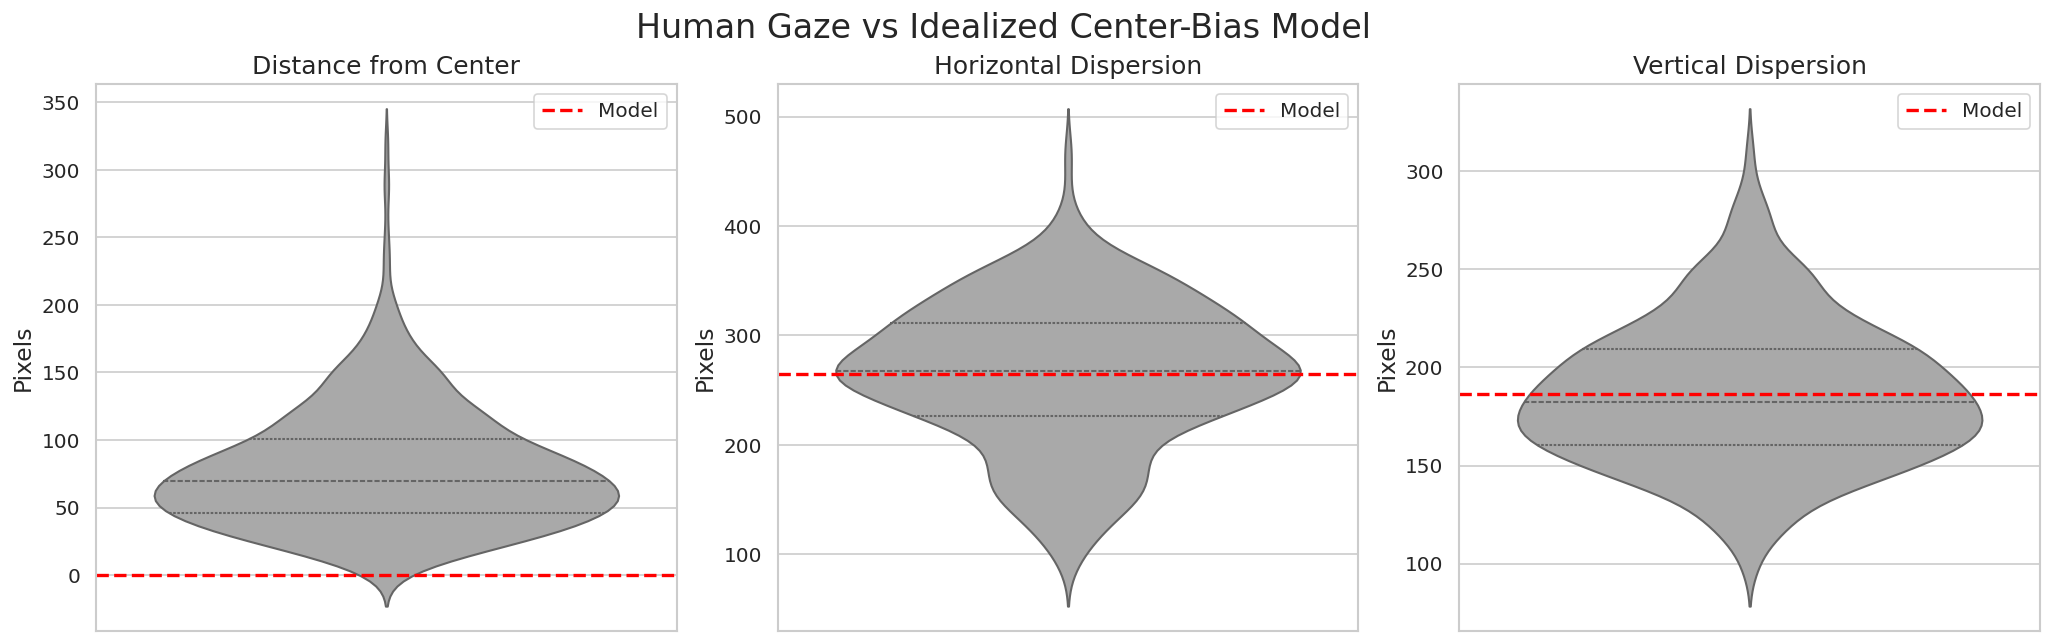

[saved] /home/nico/Projects/final_project/results/notebook01/section05/fig_human_vs_centerbias_violins.png
[saved] /home/nico/Projects/final_project/results/notebook01/section05/fig_human_vs_centerbias_violins.svg


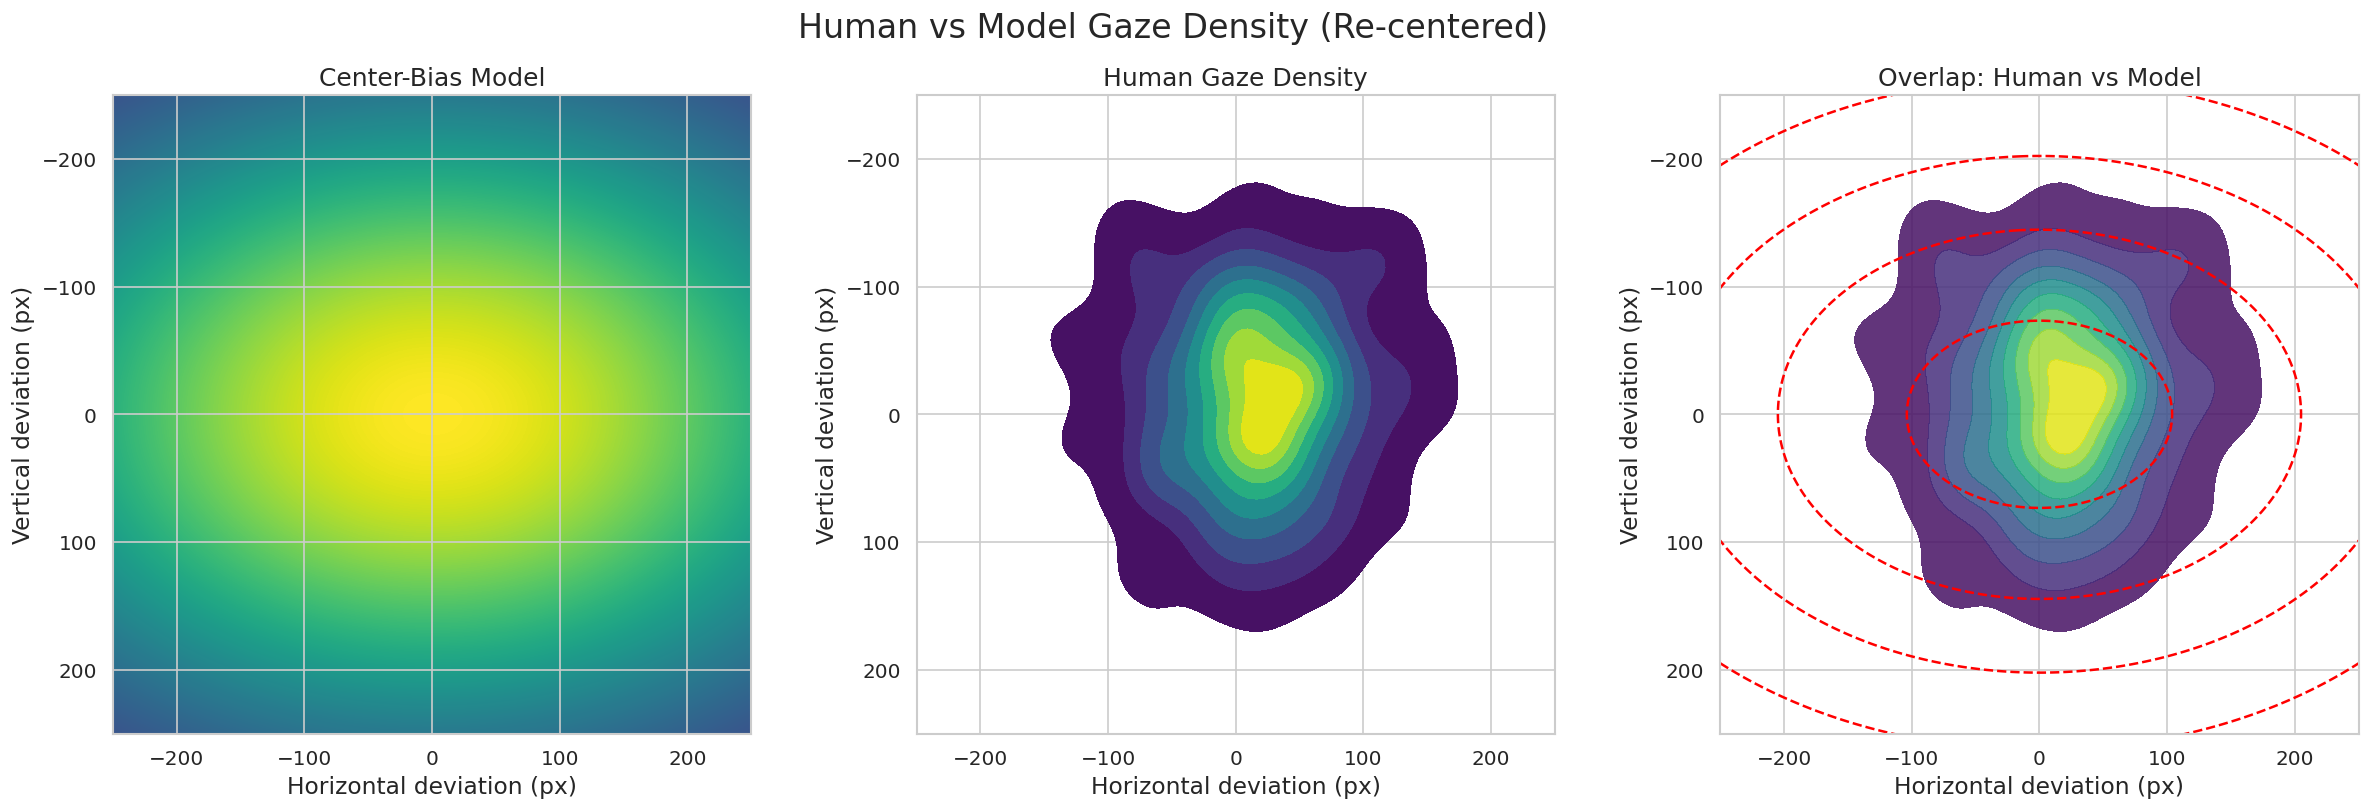

[saved] /home/nico/Projects/final_project/results/notebook01/section05/fig_human_vs_centerbias_kde_recentered.png


In [16]:
# --- Section 5: Benchmarking Against a Center Bias Model ---

def benchmark_against_center_bias(centroids_path: Path, img_w: int, img_h: int) -> None:
    """Compares human gaze against an idealized Gaussian center-bias model."""

    df_centroids = pd.read_csv(centroids_path)
    cx, cy = img_w / 2.0, img_h / 2.0
    mean_std_x = float(df_centroids["x_std"].mean())
    mean_std_y = float(df_centroids["y_std"].mean())

    # --- Model Definition ---
    cb_stats = pd.DataFrame(
        [{
            "Model": "Center Bias",
            "distance_to_center": 0.0,
            "x_std": mean_std_x,
            "y_std": mean_std_y
        }]
    )
    
    # Save and display model stats
    cb_csv = get_output_path(5, "tbl_center_bias_model_stats.csv")
    cb_md  = get_output_path(5, "tbl_center_bias_model_stats.md")
    cb_stats.to_csv(cb_csv, index=False)
    save_dataframe_as_markdown(cb_stats, cb_md, title="Center-Bias Model Statistics")
    print("\n[table] Center-bias model statistics")
    display(cb_stats)

    # --- Statistical Testing ---
    metrics = ["distance_to_center", "x_std", "y_std"]
    rows = []
    for m in metrics:
        human_vals = df_centroids[m].dropna()
        ref_val = float(cb_stats.loc[0, m])
        t_stat, p_val = ttest_1samp(human_vals, ref_val)
        rows.append({
            "Metric": m,
            "Human Mean": human_vals.mean(),
            "Model Value": ref_val,
            "T-statistic": t_stat,
            "p-value": p_val
        })
    
    ttab = pd.DataFrame(rows)
    ttab_csv = get_output_path(5, "tbl_human_vs_centerbias_tests.csv")
    ttab_md  = get_output_path(5, "tbl_human_vs_centerbias_tests.md")
    ttab.to_csv(ttab_csv, index=False)
    save_dataframe_as_markdown(ttab, ttab_md, title="T-tests: Human vs Center-Bias Model")
    print("\n[table] T-tests: Human vs Center-bias model")
    display(ttab.round({"Human Mean": 3, "Model Value": 3, "T-statistic": 3}))

    # -----------------------------
    # Visualization 
    # -----------------------------
    TITLE_FS = 20
    SUBTITLE_FS = 15
    LABEL_FS = 14
    TICK_FS = 12
    LEGEND_FS = 12

    # --- Violin plots ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=config.FIG_DPI)
    fig.suptitle("Human Gaze vs Idealized Center-Bias Model", fontsize=TITLE_FS)

    titles = ["Distance from Center", "Horizontal Dispersion", "Vertical Dispersion"]
    for i, m in enumerate(metrics):
        ax = axes[i]
        sns.violinplot(ax=ax, data=df_centroids, y=m, color="#A9A9A9", inner="quartile")
        ax.axhline(float(cb_stats.loc[0, m]), color="red", linestyle="--", lw=2, label="Model")
        ax.set_title(titles[i], fontsize=SUBTITLE_FS)
        ax.set_xlabel(None)
        ax.set_ylabel("Pixels", fontsize=LABEL_FS)
        ax.tick_params(axis="both", which="major", labelsize=TICK_FS)
        ax.legend(fontsize=LEGEND_FS, loc="upper right")

    fig.tight_layout(rect=[0, 0, 1, 0.93])
    fig.subplots_adjust(left=0.08, right=0.98, bottom=0.12, top=0.88)

    v_png = get_output_path(5, "fig_human_vs_centerbias_violins.png")
    v_svg = get_output_path(5, "fig_human_vs_centerbias_violins.svg")
    plt.savefig(v_png, bbox_inches="tight"); plt.savefig(v_svg, bbox_inches="tight"); plt.show()
    print(f"[saved] {v_png}")
    print(f"[saved] {v_svg}")

    # --- Gaussian center-bias map and KDE comparison ---
    x_grid, y_grid = np.meshgrid(np.arange(img_w), np.arange(img_h))
    expo = -(((x_grid - cx) ** 2) / (2.0 * mean_std_x ** 2) + ((y_grid - cy) ** 2) / (2.0 * mean_std_y ** 2))
    cb_map = np.exp(expo); cb_map /= cb_map.sum()

    df_rc = df_centroids.copy()
    if "x_mean" in df_rc.columns and "y_mean" in df_rc.columns:
        df_rc["x_mean_recenter"] = df_rc["x_mean"] - cx
        df_rc["y_mean_recenter"] = df_rc["y_mean"] - cy

        fig, axes = plt.subplots(1, 3, figsize=(21, 7), dpi=config.FIG_DPI)
        fig.suptitle("Human vs Model Gaze Density (Re-centered)", fontsize=TITLE_FS)

        # Model density
        im = axes[0].imshow(cb_map, cmap="viridis",
                            extent=[-img_w/2, img_w/2, img_h/2, -img_h/2])
        axes[0].set_title("Center-Bias Model", fontsize=SUBTITLE_FS)

        # Human KDE
        sns.kdeplot(
            ax=axes[1],
            data=df_rc,
            x="x_mean_recenter", y="y_mean_recenter",
            fill=True, cmap="viridis", thresh=0.05
        )
        axes[1].set_title("Human Gaze Density", fontsize=SUBTITLE_FS)

        # Overlay
        sns.kdeplot(
            ax=axes[2],
            data=df_rc,
            x="x_mean_recenter", y="y_mean_recenter",
            fill=True, cmap="viridis", alpha=0.85, thresh=0.05
        )
        axes[2].contour(x_grid - cx, y_grid - cy, cb_map, levels=5,
                        colors="red", linestyles="--", linewidths=1.5)
        axes[2].set_title("Overlap: Human vs Model", fontsize=SUBTITLE_FS)

        for ax in axes:
            ax.set_xlabel("Horizontal deviation (px)", fontsize=LABEL_FS)
            ax.set_ylabel("Vertical deviation (px)", fontsize=LABEL_FS)
            ax.tick_params(axis="both", which="major", labelsize=TICK_FS)
            ax.set_aspect("equal", adjustable="box")
            ax.set_xlim(-250, 250)
            ax.set_ylim(250, -250)

        fig.tight_layout(rect=[0, 0, 1, 0.93])
        fig.subplots_adjust(left=0.07, right=0.98, bottom=0.12, top=0.88)

        k_png = get_output_path(5, "fig_human_vs_centerbias_kde_recentered.png")
        k_svg = get_output_path(5, "fig_human_vs_centerbias_kde_recentered.svg")
        plt.savefig(k_png, bbox_inches="tight"); plt.savefig(k_svg, bbox_inches="tight"); plt.show()
        print(f"[saved] {k_png}")
    else:
        print("[warn] x_mean/y_mean columns not found; skipping KDE overlay.")

# --- Execute ---
benchmark_against_center_bias(
    centroids_path=get_output_path(4,"fixation_centroid_stats_full.csv"),
    img_w=config.IMG_WIDTH,
    img_h=config.IMG_HEIGHT
)

**Results**

The benchmark against the idealized Gaussian model revealed statistically significant differences in human gaze behavior. The mean distance of human fixation centroids from the geometric center was 78.56 pixels, which is significantly greater than the model's value of 0 (p < 0.001). While the mean horizontal and vertical dispersions of human gaze were matched to the model by design, the distributions were notably different. The violin plots show that the human data distributions are broader and flatter (i.e., have higher kurtosis) than a simple Gaussian would predict.

**Interpretation**

The significant deviation of human centroids from the perfect center quantitatively confirms that gaze allocation cannot be explained by a simple center reflex. Instead, scene content is likely pulling fixations toward salient regions. The broader, heavy-tailed distributions for dispersion suggest that while gaze is typically concentrated, viewers make more frequent large, exploratory saccades than would be expected under a simple center-bias model. These exploratory fixations are likely driven by the semantic content located away from the central region.

**Conclusion**

Human gaze behavior exhibits a robust central tendency, but is also modulated by the content of the visual scene. The simple center-bias model is insufficient to explain the observed patterns, providing motivation to proceed with analyses that explicitly account for the semantic category of the images.

---

### **Section 6: Anthropomorphic vs. Non-anthropomorphic Gaze Confirmatory Analysis**

**Objective**

To test the primary hypothesis that categories containing anthropomorphic content (Affective, Social, and Action) elicit different aggregate gaze patterns compared to scenes without a human focus (Indoor, OutdoorManMade, and OutdoorNatural).

**Rationale**

This analysis provides a formal, quantitative test of the well-established theory that humans prioritize social and agent-driven stimuli. By comparing multiple gaze metrics across these two fundamental semantic groups, we can confirm the presence of top-down attentional modulation in the CAT2000 dataset, validating its use for more detailed studies.

**Methodology**

The six CAT2000 categories were partitioned into two groups: Anthropomorphic and Non-anthropomorphic. Five key gaze metrics were compared between these groups using two-sided Mann-Whitney U tests. The familywise error rate was controlled using the Holm-Bonferroni correction. Effect sizes are reported as the signed rank-biserial correlation for the Anthropomorphic > Non-anthropomorphic direction.

**Inputs**

*   `results/notebook01/section03/fixation_map_stats_full.csv`: Per-image fixation statistics from Section 3.
*   `results/notebook01/section04/fixation_centroid_stats_full.csv`: Per-image centroid statistics from Section 4.

**Outputs**

*   `results/notebook01/section06/tbl_anthropomorphic_vs_nonanthropomorphic_tests.csv`: Summary tables of the statistical tests.
*   `results/notebook01/section06/tbl_anthropomorphic_vs_nonanthropomorphic_effect_sizes.csv`: Summary tables of effect sizes.
*   `results/notebook01/section06/fig_anthropomorphic_vs_nonanthropomorphic_distributions.png`: Boxplots comparing the distributions for each metric.

[saved] /home/nico/Projects/final_project/results/notebook01/section06/tbl_anthropomorphic_vs_nonanthropomorphic_tests.md

[table] Anthropomorphic vs Non-anthropomorphic: Mann-Whitney U with Holm-Bonferroni


Metric  Anthropomorphic Mean  Non-anthropomorphic Mean  rank_biserial  p_raw  p_corrected
0  unique_fixation_count               359.530                   338.727          0.344   0.00        0.000
1                entropy                 8.483                     8.397          0.344   0.00        0.000
2     distance_to_center                86.030                    71.089          0.166   0.00        0.001
3                  x_std               253.682                   274.950         -0.178   0.00        0.000
4                  y_std               189.597                   183.511          0.097   0.04        0.040

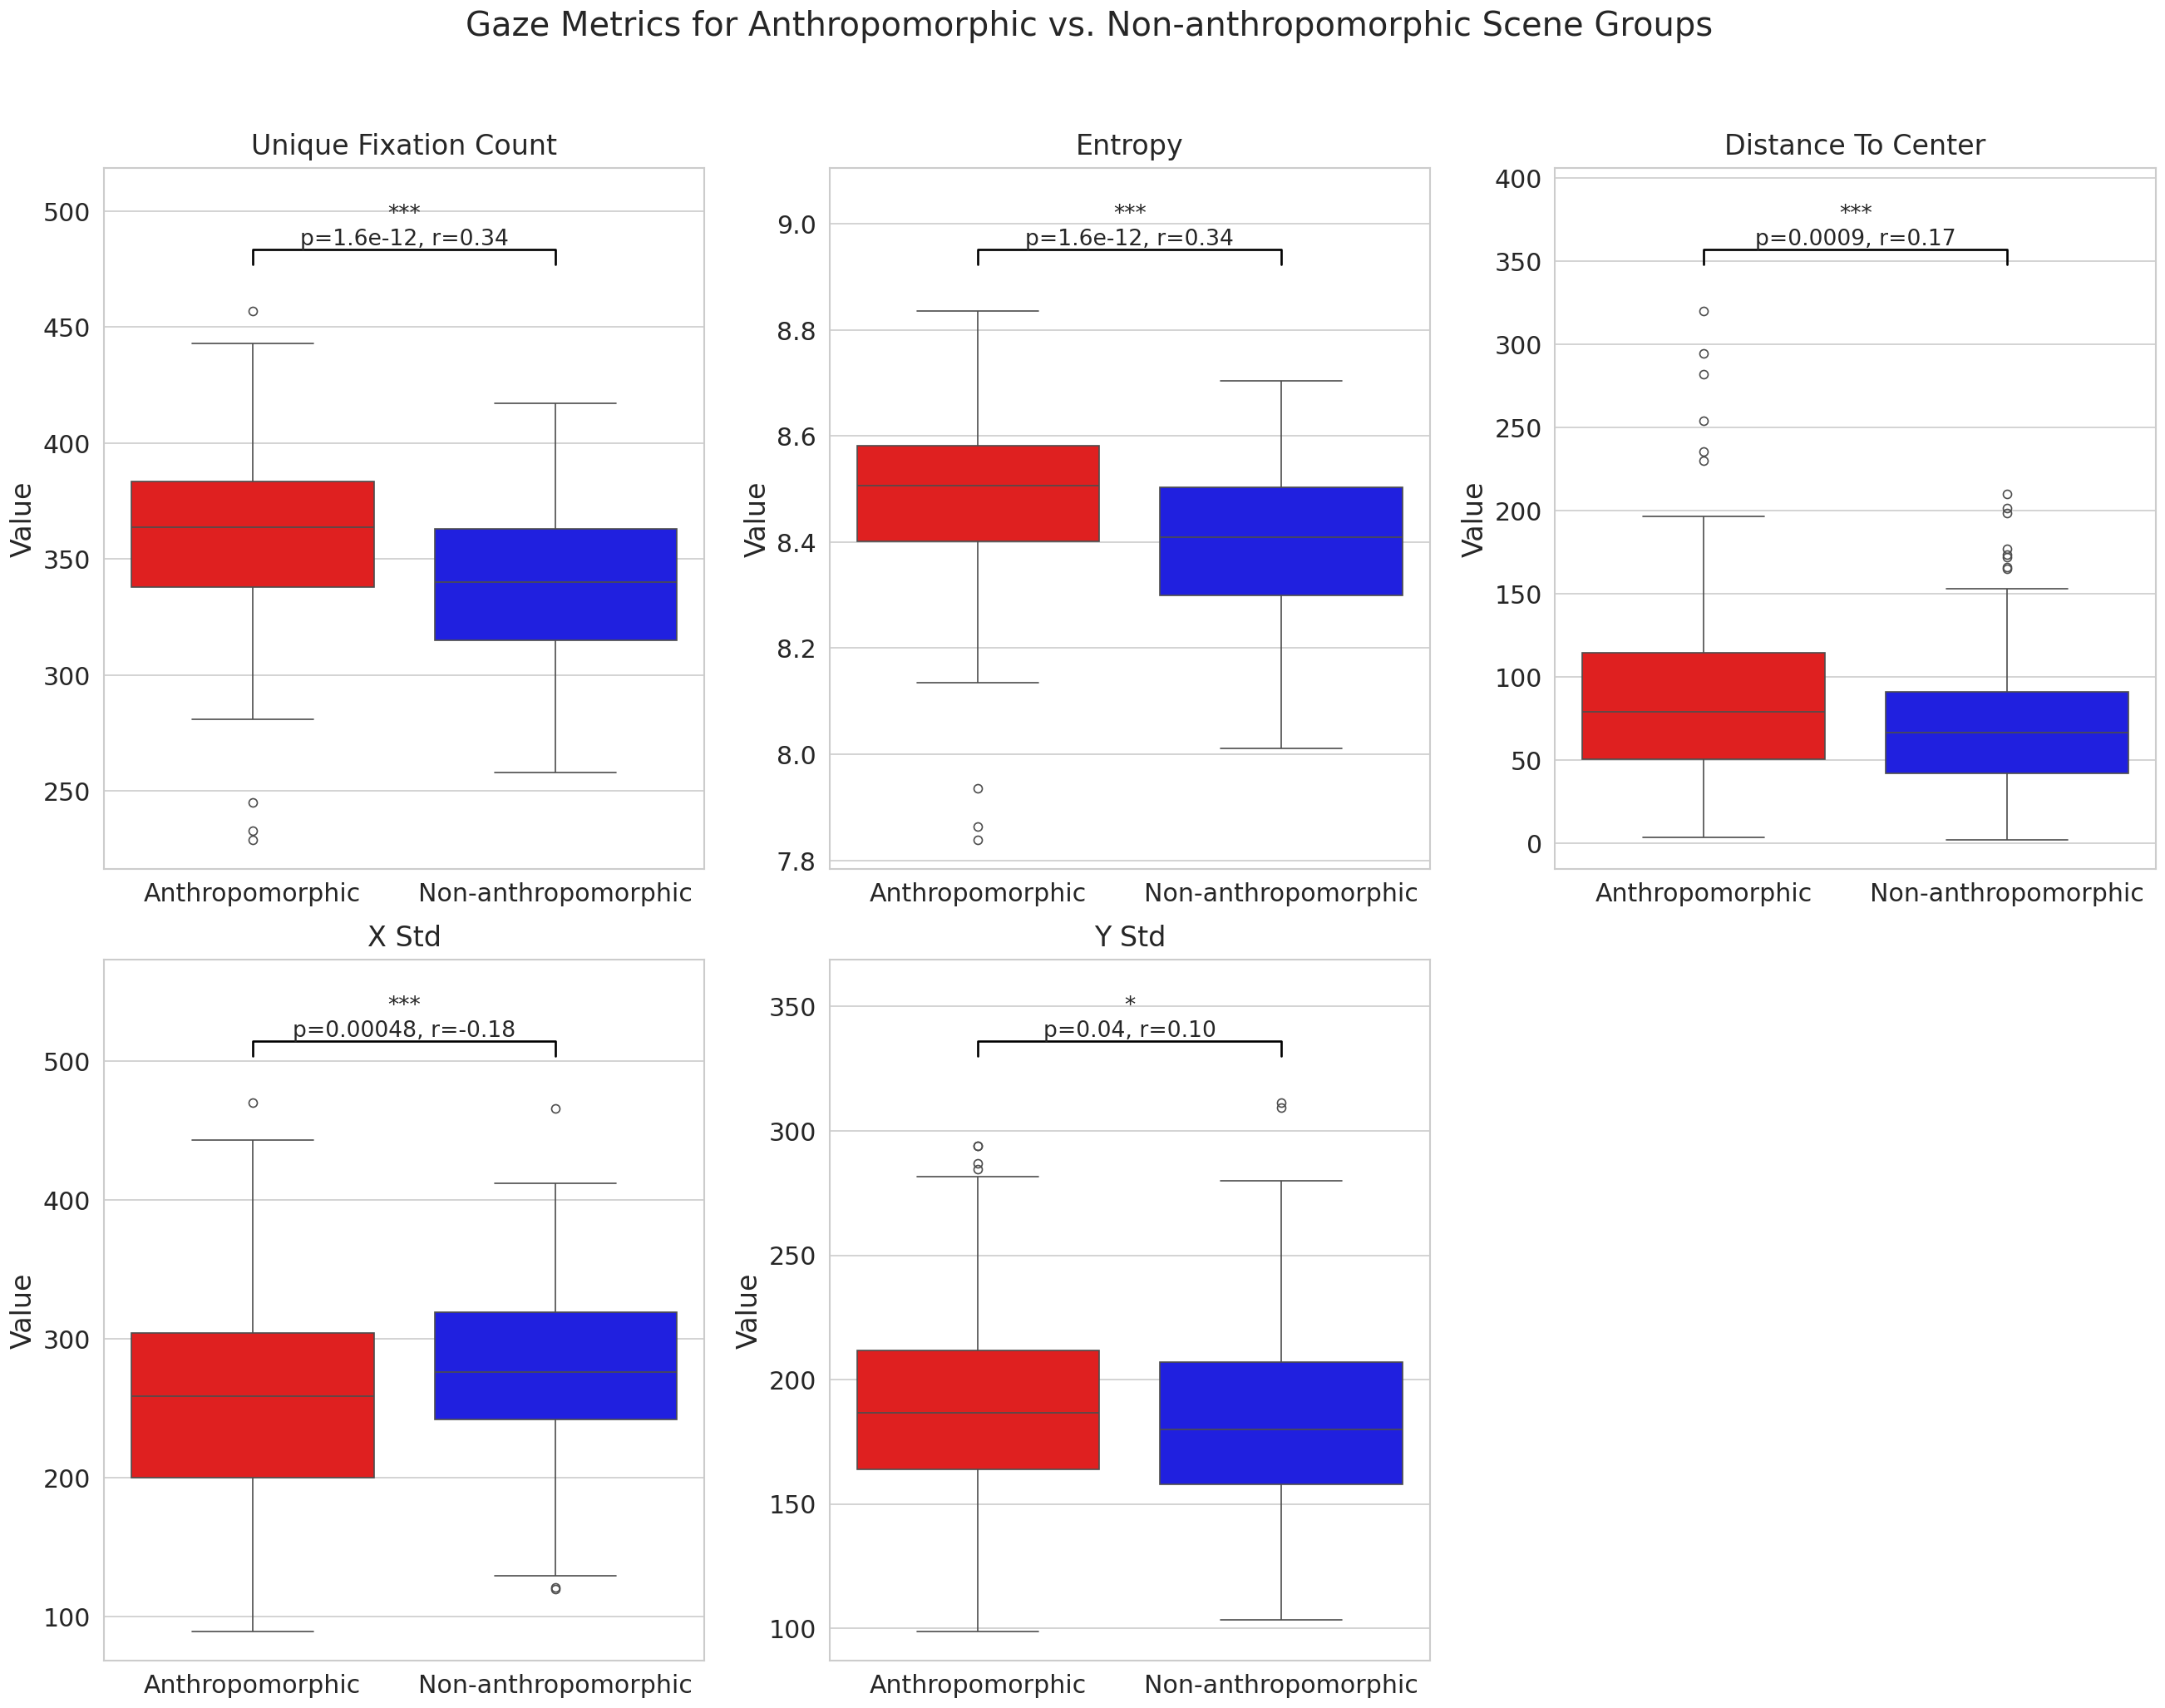

In [18]:
# --- Section 6: Anthropomorphic vs. Non-anthropomorphic Gaze Confirmatory Analysis ---

def _rank_biserial_signed(u_greater: float, n1: int, n2: int) -> float:
    """Calculates signed rank-biserial correlation for Anthropomorphic > Non-anthropomorphic."""
    return (2.0 * u_greater) / (n1 * n2) - 1.0

def _z_from_u_twosided(u_min: float, n1: int, n2: int) -> float:
    """Calculates normal-approximation z-score from Mann-Whitney U."""
    mean_u = n1 * n2 / 2.0
    sd_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0)
    return (u_min - mean_u) / sd_u

def _add_stat_annotation(ax, p_value: float, r_value: float, y_max: float):
    """Adds a significance bracket to a plot."""
    stars = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    bar = y_max + 0.08 * y_range
    tip = bar + 0.025 * y_range
    ax.plot([0, 0, 1, 1], [bar, tip, tip, bar], lw=config.PLOT_LINEWIDTH, c="k")
    ax.text(0.5, tip, f"{stars}\np={p_value:.2g}, r={r_value:.2f}", ha="center", va="bottom", fontsize=16)
    ax.set_ylim(ax.get_ylim()[0], tip + 0.14 * y_range)

# --- Main Analysis Function ---

def anthropomorphic_vs_nonanthropomorphic_analysis(stats_path: Path, centroids_path: Path) -> pd.DataFrame:
    """Compares gaze metrics between Anthropomorphic and Non-anthropomorphic scene categories."""
    df_stats = pd.read_csv(stats_path)
    df_cent = pd.read_csv(centroids_path)
    df = pd.merge(df_stats, df_cent, on=["category", "filename"], how="inner")
    df["group"] = np.where(df["category"].isin(config.ANTHROPOMORPHIC_CATEGORIES), "Anthropomorphic", "Non-anthropomorphic")

    metrics = ["unique_fixation_count", "entropy", "distance_to_center", "x_std", "y_std"]
    rows, p_raw = [], []

    for m in metrics:
        g1 = df.loc[df["group"] == "Anthropomorphic", m].dropna()
        g2 = df.loc[df["group"] == "Non-anthropomorphic", m].dropna()
        u_two, p_two = mannwhitneyu(g1, g2, alternative="two-sided")
        u_greater, _ = mannwhitneyu(g1, g2, alternative="greater")
        rows.append({
            "Metric": m, "Anthropomorphic Mean": g1.mean(), "Non-anthropomorphic Mean": g2.mean(),
            "rank_biserial": _rank_biserial_signed(u_greater, len(g1), len(g2)),
            "p_raw": p_two
        })
        p_raw.append(p_two)

    _, p_corr, _, _ = multipletests(p_raw, alpha=0.05, method="holm")
    results = pd.DataFrame(rows)
    results["p_corrected"] = p_corr
    
    # --- Save and Display Results ---
    stats_csv = get_output_path(6, "tbl_anthropomorphic_vs_nonanthropomorphic_tests.csv")
    stats_md = get_output_path(6, "tbl_anthropomorphic_vs_nonanthropomorphic_tests.md")
    results_rounded = results.round(config.DEFAULT_DECIMALS)
    results_rounded.to_csv(stats_csv, index=False)
    save_dataframe_as_markdown(results_rounded, stats_md, title="Anthropomorphic vs Non-anthropomorphic: Corrected Tests")
    
    print("\n[table] Anthropomorphic vs Non-anthropomorphic: Mann-Whitney U with Holm-Bonferroni")
    display(results_rounded)

    # --- Visualization ---
    fig, axes = plt.subplots(2, 3, figsize=(22, 18), dpi=config.FIG_DPI)
    axes = axes.flatten()
    fig.suptitle("Gaze Metrics for Anthropomorphic vs. Non-anthropomorphic Scene Groups", fontsize=24)
    for i, m in enumerate(metrics):
        sns.boxplot(ax=axes[i], data=df, x="group", y=m, order=["Anthropomorphic", "Non-anthropomorphic"], hue="group",
                    palette={"Anthropomorphic": 'red', "Non-anthropomorphic": 'blue'}, legend=False)
        axes[i].set_title(m.replace("_", " ").title(), fontsize=20, pad=10)
        axes[i].set_xlabel(None)
        axes[i].set_ylabel("Value", fontsize=20)
        axes[i].tick_params(axis='x', labelsize=18)
        axes[i].tick_params(axis='y', labelsize=18)
        _add_stat_annotation(axes[i], results.loc[i, "p_corrected"], results.loc[i, "rank_biserial"], df[m].max())
        
    fig.delaxes(axes[-1])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_png = get_output_path(6, "fig_anthropomorphic_vs_nonanthropomorphic_distributions.png")
    fig_svg = get_output_path(6, "fig_anthropomorphic_vs_nonanthropomorphic_distributions.svg")
    plt.savefig(fig_png); plt.savefig(fig_svg); plt.show()
    
    return results

# --- Execute ---
results_section6 = anthropomorphic_vs_nonanthropomorphic_analysis(
    stats_path=get_output_path(3,"fixation_map_stats_full.csv"),
    centroids_path=get_output_path(4,"fixation_centroid_stats_full.csv"),
)

**Results**

The Holm-Bonferroni-corrected Mann-Whitney U tests identified significant differences between Anthropomorphic and Non-anthropomorphic scenes on all five metrics (*N* = 300 per group).

* **Exploratory breadth:** `unique_fixation_count` was significantly higher for Anthropomorphic images ($\bar{x}=359.530$ vs. $338.727$; rank-biserial $r=0.344$, $p_{\text{corrected}}=1.639\times 10^{-12}$).
* **Gaze dispersion:** `entropy` was significantly higher for Anthropomorphic images ($\bar{x}=8.483$ vs. $8.397$ bits; rank-biserial $r=0.344$, $p_{\text{corrected}}=1.639\times 10^{-12}$).
* **Center bias:** `distance_to_center` was significantly greater for Anthropomorphic images ($\bar{x}=86.030$ vs. $71.089$ px; rank-biserial $r=0.166$, $p_{\text{corrected}}=9.002\times 10^{-4}$).
* **Horizontal dispersion:** `x_std` was significantly smaller for Anthropomorphic images ($\bar{x}=253.682$ vs. $274.950$ px; rank-biserial $r=-0.178$, $p_{\text{corrected}}=4.811\times 10^{-4}$).
* **Vertical dispersion:** `y_std` was significantly larger for Anthropomorphic images ($\bar{x}=189.597$ vs. $183.511$ px; rank-biserial $r=0.097$, $p_{\text{corrected}}=3.967\times 10^{-2}$).

**Interpretation**

The results provide strong evidence that the presence of anthropomorphic content systematically modulates aggregate gaze behavior. Scenes containing humans or depicting human actions lead to broader (`unique_fixation_count`) and more uniform (`entropy`) visual exploration. This is consistent with the idea that social stimuli contain multiple, distributed regions of interest (faces, hands, bodies) that encourage more extensive viewing.

The spatial organization of gaze also differs significantly. The greater `distance_to_center` for anthropomorphic scenes confirms that viewers’ attention is drawn away from the image center toward the locations of people. Furthermore, the pattern of dispersion is anisotropic: the tighter horizontal spread (`x_std`) combined with a wider vertical spread (`y_std`) suggests a viewing strategy adapted to the typically vertical orientation of human figures.

**Conclusion**

The analysis confirms a clear and statistically robust distinction between how viewers observe anthropomorphic and non-anthropomorphic scenes. The presence of social content prompts a shift from a default center-biased viewing mode to a more exploratory pattern that is spatially tuned to the expected locations and structure of human figures. These findings validate the dataset’s sensitivity to high-level semantic content and support the primary hypotheses of the project.
